In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

### 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#read the file
train_diff152 = pd.read_csv('/content/drive/MyDrive/일반화선형모형/train_diff152.csv')
vali_diff152 = pd.read_csv('/content/drive/MyDrive/일반화선형모형/vali_diff152.csv')
test_diff152 = pd.read_csv('/content/drive/MyDrive/일반화선형모형/test_diff152.csv')

In [4]:
new_train152 = pd.concat([train_diff152, vali_diff152.iloc[:120]])
new_val152 =  vali_diff152.iloc[120:]
new_test152 = test_diff152

In [5]:
new_train152 = new_train152.set_index('일자')
new_val152 = new_val152.set_index('일자')
new_test152 = new_test152.set_index('일자')

### 스케일링

In [6]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train = scaler.fit_transform(new_train152)
scaled_vali = scaler.transform(new_val152)
scaled_test = scaler.transform(new_test152)

### GPU

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


### 데이터 전처리

In [9]:
y_trainer = scaled_train[:,0]
y_valier = scaled_vali[:,0]

In [10]:
# sequence 길이 정해주는 함수
def seq_data(y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(y) - sequence_length):
    x_seq.append(y[i: i+sequence_length]) # sequence_length 길이만큼의 x ex)5일치의 시가, 고가, 저가, 거래량 sequence
    y_seq.append(y[i+sequence_length]) # sequence_length+1 번째 종가 ex) 6일차의 종가 

  return torch.FloatTensor(x_seq).to(device).unsqueeze(2), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.

In [11]:
sequence_length = 7
x_seq_train, y_seq_train = seq_data(y_trainer, sequence_length)
x_seq_vali, y_seq_vali = seq_data(y_valier, sequence_length)
#x_seq_test, y_seq_test = seq_data(scaled_test, scaled_vali[:,0], sequence_length)

print(x_seq_train.size(), y_seq_train.size())
print(x_seq_vali.size(), y_seq_vali.size())
#print(x_seq_test.size(), y_seq_test.size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  # Remove the CWD from sys.path while we load stuff.


torch.Size([685, 7, 1]) torch.Size([685, 1])
torch.Size([24, 7, 1]) torch.Size([24, 1])


In [12]:
train = torch.utils.data.TensorDataset(x_seq_train, y_seq_train)
vali = torch.utils.data.TensorDataset(x_seq_vali, y_seq_vali) 
#test = torch.utils.data.TensorDataset(x_seq_test, y_seq_test) 

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False) # batch size=20으로 train, test dataloader 지정
vali_loader = torch.utils.data.DataLoader(dataset=vali, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

### 모델링

In [13]:
class LSTM(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # nonlinearity=tanh (default)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 cell state 설정하기.
    out, (hn,cn) = self.lstm(x, (h0, c0)) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state, cn: cell state
    out = self.fc(out[:,-1,:]) # (batch_size, hidden_size) 
    return out

In [14]:
# dropout 추가
class LSTM2(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, dropout, device):
    super(LSTM2, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2) # nonlinearity=tanh (default) 변경 불가능
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 cell state 설정하기.
    out, (hn,cn) = self.lstm(x, (h0, c0)) # out: RNN의 마지막 레이어로부터 나온 output feature 를 반환한다. hn: hidden state, cn: cell state
    out = self.fc(out[:,-1,:]) # (batch_size, hidden_size) 
    return out
    

### 그래프 함수

In [15]:
def plotting(train_loader, vali_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in vali_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

### 모델 학습

#### case1

In [16]:
num_epochs = 500 
lr = 0.001 

input_size = 1 #number of features
hidden_size = 8 #number of features in hidden state
#num_layers = 2 #number of stacked lstm layers

model = LSTM2(input_size, hidden_size, sequence_length=7, num_layers=2, dropout=0.3, device=device).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # adam optimizer

loss_graph_train = [] # 그래프 그릴 목적인 loss.
loss_graph_valid = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0
  valid_losses = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.
    pred = model(seq)   # 모델에 넣고,
    loss = loss_function(pred, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  for dataa in vali_loader :
    # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
    seq1, target1 = dataa # 배치 데이터.
    pred1 = model(seq1)
    # calculate the loss
    loss1 = loss_function(pred1, target1)
    # record validation loss
    valid_losses += loss1.item()

  loss_graph_train.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  loss_graph_valid.append(valid_losses / n)
  if epoch % 20 == 0:
    print('[epoch: %d] loss: %.4f val_loss: %.4f'%(epoch, running_loss/n, valid_losses / n))

[epoch: 0] loss: 0.1898 val_loss: 0.0038
[epoch: 20] loss: 0.0097 val_loss: 0.0022
[epoch: 40] loss: 0.0097 val_loss: 0.0023
[epoch: 60] loss: 0.0098 val_loss: 0.0023
[epoch: 80] loss: 0.0098 val_loss: 0.0023
[epoch: 100] loss: 0.0096 val_loss: 0.0022
[epoch: 120] loss: 0.0093 val_loss: 0.0021
[epoch: 140] loss: 0.0090 val_loss: 0.0021
[epoch: 160] loss: 0.0089 val_loss: 0.0021
[epoch: 180] loss: 0.0086 val_loss: 0.0020
[epoch: 200] loss: 0.0080 val_loss: 0.0017
[epoch: 220] loss: 0.0083 val_loss: 0.0015
[epoch: 240] loss: 0.0080 val_loss: 0.0014
[epoch: 260] loss: 0.0077 val_loss: 0.0013
[epoch: 280] loss: 0.0078 val_loss: 0.0019
[epoch: 300] loss: 0.0080 val_loss: 0.0016
[epoch: 320] loss: 0.0072 val_loss: 0.0014
[epoch: 340] loss: 0.0072 val_loss: 0.0012
[epoch: 360] loss: 0.0074 val_loss: 0.0013
[epoch: 380] loss: 0.0074 val_loss: 0.0013
[epoch: 400] loss: 0.0074 val_loss: 0.0014
[epoch: 420] loss: 0.0070 val_loss: 0.0012
[epoch: 440] loss: 0.0070 val_loss: 0.0011
[epoch: 460] loss

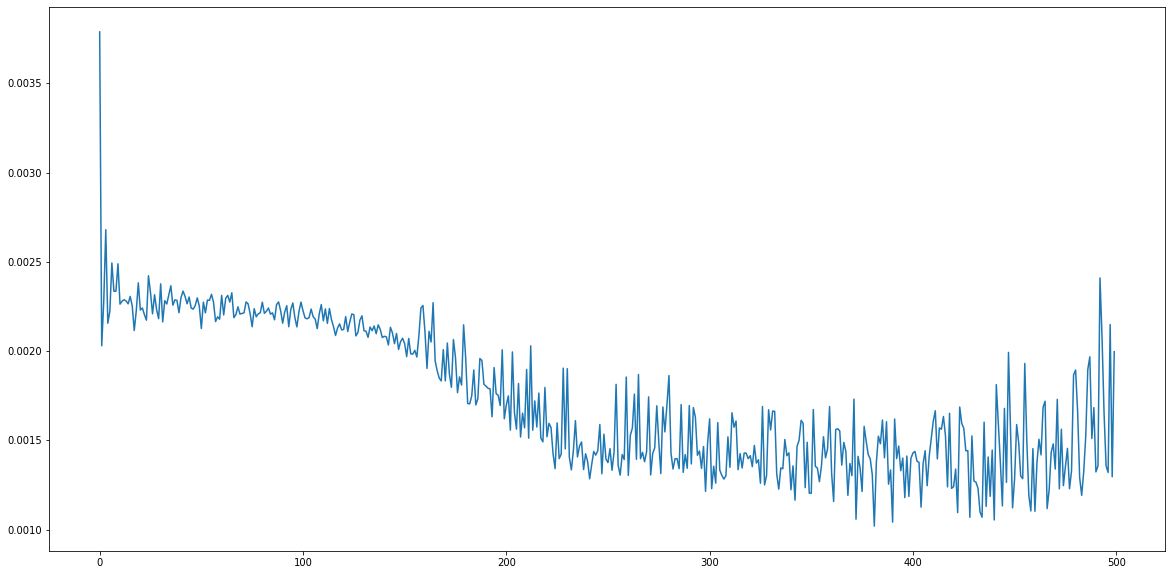

In [17]:
plt.figure(figsize=(20,10))
#plt.plot(loss_graph_train)   # train loss 
plt.plot(loss_graph_valid)   # valid loss
plt.show()

In [18]:
y = scaled_train[:,0]

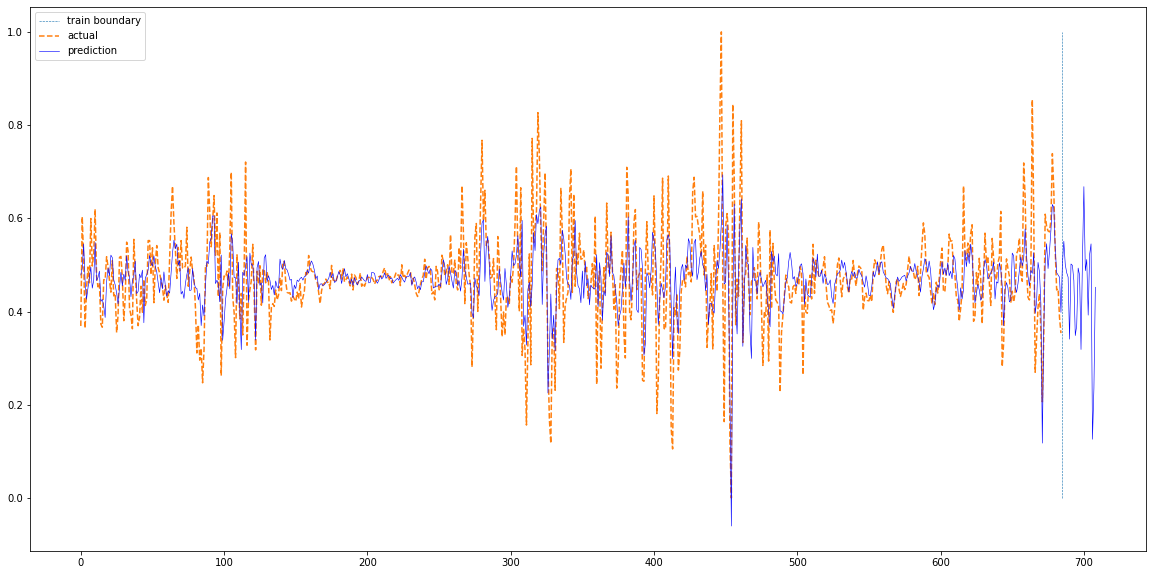

In [19]:
# train/valid 예측 그래프
plotting(train_loader, vali_loader, y[sequence_length:,])

In [20]:
# validation prediction
with torch.no_grad():
  test_pred = []
  for data in vali_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()

vali_predict_true = pd.concat([pd.DataFrame(test_pred), pd.DataFrame(y_seq_vali.tolist())], axis=1)
vali_predict_true.columns = ['predicted', 'true']

#vali_predict_true.info()
val_rmse1 = np.sqrt(((vali_predict_true['predicted'] - vali_predict_true['true'])**2).mean())
val_rmse1

0.18915374769549634

## Test data setting


In [21]:
#read the file
train_diff152 = pd.read_csv('/content/drive/MyDrive/GLM_Final_Project/차분후데이터/train_diff152.csv')
vali_diff152 = pd.read_csv('/content/drive/MyDrive/GLM_Final_Project/차분후데이터/vali_diff152.csv')
test_diff152 = pd.read_csv('/content/drive/MyDrive/GLM_Final_Project/차분후데이터/test_diff152.csv')

FileNotFoundError: ignored

In [ ]:
new_train152 = pd.concat([train_diff152, vali_diff152.iloc[:120]])
new_val152 =  vali_diff152.iloc[120:]
new_test152 = test_diff152

In [ ]:
new_train152 = new_train152.set_index('일자')
new_val152 = new_val152.set_index('일자')
new_test152 = new_test152.set_index('일자')

In [22]:
# 1. 데이터 생성
final_train = new_train152 # train 데이터만 이용하기
final_test = pd.concat([new_val152[-7:],new_test152],axis=0) # for predict

In [23]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

final_train = scaler.fit_transform(final_train)
final_test = scaler.transform(final_test)

### 데이터 전처리

In [24]:
y_trainer = final_train[:,0]
y_test = final_test[:,0]

In [25]:
# sequence 길이 정해주는 함수
def seq_data(y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(y) - sequence_length):
    x_seq.append(y[i: i+sequence_length]) # sequence_length 길이만큼의 x ex)5일치의 시가, 고가, 저가, 거래량 sequence
    y_seq.append(y[i+sequence_length]) # sequence_length+1 번째 종가 ex) 6일차의 종가 

  return torch.FloatTensor(x_seq).to(device).unsqueeze(2), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.

In [26]:
sequence_length = 7
x_seq_train, y_seq_train = seq_data(y_trainer, sequence_length)
x_seq_test, y_seq_test = seq_data(y_test, sequence_length)
#x_seq_test, y_seq_test = seq_data(scaled_test, scaled_vali[:,0], sequence_length)

print(x_seq_train.size(), y_seq_train.size())
print(x_seq_test.size(), y_seq_test.size())
#print(x_seq_test.size(), y_seq_test.size())

torch.Size([685, 7, 1]) torch.Size([685, 1])
torch.Size([30, 7, 1]) torch.Size([30, 1])


In [27]:
train = torch.utils.data.TensorDataset(x_seq_train, y_seq_train)
test = torch.utils.data.TensorDataset(x_seq_test, x_seq_test) 
#test = torch.utils.data.TensorDataset(x_seq_test, y_seq_test) 

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False) # batch size=20으로 train, test dataloader 지정
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

#### test 예측값 확인

In [28]:
y = final_test[:,0] # 대여수 ????

In [29]:
# test에서의 예측과 실제

def plotting(valid_loader, actual):
  
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in valid_loader:
      seq, target = data
      out = model(seq) # 아까 만든 모델 이용해서 그냥 예측만하기!!
      test_pred += out.cpu().numpy().tolist()
      
  total = test_pred
  plt.figure(figsize=(5,3))
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['actual', 'prediction'])
  plt.show()
  
  return total , actual



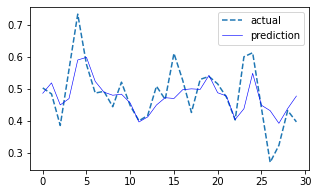

차분/scale data 결과
0    0.06788
dtype: float64
0    0.047577
dtype: float64


In [30]:
test_pred, actual = plotting(test_loader, y[sequence_length:,])

print("차분/scale data 결과")
print(np.sqrt((pd.DataFrame(test_pred) - pd.DataFrame(actual)).pow(2).mean())) # rmse
print(abs(pd.DataFrame(test_pred) - pd.DataFrame(actual)).mean()) # rmse

####차분후

In [31]:
# 원래대로 되돌리기
len(final_test) # 37개여야 함 (30개 예측을 위해서)

37

In [32]:
len(test_pred)

30

In [33]:
# 차분 / scaling 원래대로 되돌리기
# 1.scaling 되돌리기
for_inverse = pd.DataFrame(final_test[7:]) # scaling된 예측 전 데이터판 가지고오기
for_inverse[0] = pd.DataFrame(test_pred)[0].tolist() # 예측 된 데이터 되돌려야하는 거니까 예측 후 데이터로 바꿔주기
compare_data= pd.DataFrame(scaler.inverse_transform(for_inverse)) # 예측 된 데이터로 scale 되돌리기

In [36]:
# 2.차분 되돌리기
raw_vali = pd.read_csv('/content/drive/MyDrive/일반화선형모형/vali_152.csv') # 차분전 데이터 가지고 와야함
raw_test = pd.read_csv('/content/drive/MyDrive/일반화선형모형/test_152.csv')

for_diff = compare_data[0] # 예측 데이터 차분 되돌리기 위해 만들기

In [37]:
first= for_diff[0:7].to_list() + raw_vali[-7:].대여수 # 내가 알고 있는 valid + 차분
print(len(first)) #7

first = first.append(for_diff[7:14].to_list() + first) # 예측 된 것 + 차분
print(len(first)) #14

first = first.append(for_diff[14:21].to_list() + first[7:]) # 예측 된 것 + 차분
print(len(first)) # 21

first = first.append(for_diff[21:28].to_list() + first[14:]) # 예측 된 것 + 차분
print(len(first)) # 28

first = first.append(for_diff[28:].to_list() + first[21:23]) # 예측 된 것 + 차분
print(len(first)) # 30

7
14
21
28
30


In [38]:
final_data= pd.DataFrame(first).reset_index().drop(['index'],axis=1) # 되돌린 최종데이터

In [39]:
print(len(final_data)) # 30
print(len(raw_test)) # 30

30
30


In [40]:
# 되돌린 최종데이터, "군집 내" 평균의 rmse / mae
print(abs(raw_test.대여수 - final_data.대여수).mean()) # mae
print(np.sqrt((raw_test.대여수 - final_data.대여수).pow(2).mean())) # rmse

92.15036933124065
125.98748770278034


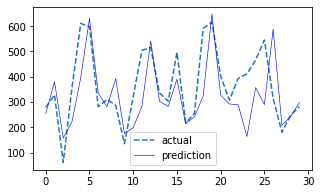

In [41]:
plt.figure(figsize=(5,3))
plt.plot(raw_test.대여수, '--')
plt.plot(final_data.대여수.to_list(), 'b', linewidth=0.6)

plt.legend(['actual', 'prediction'])
plt.show()